In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as npr

import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

np.random.seed(69420)

XGBoost version: 1.7.4


## Creating a dataset
We created a dataset which features a sine wave, a square and a circle to classify

In [3]:
def classify(a,b):
    r=0
    if (b > np.sin(2*a)+a) or (a > 8 and b < 2):
        r=1
    if ((a-2)**2 + (b-8)**2 < 1):
        r=0
    return int(r)

In [4]:
N=3000
X = 10*npr.rand(N,2)
y = np.zeros(N)
for i in range(N):
    y[i]=classify(X[i,0],X[i,1])

Text(0.5, 1.0, 'Data')

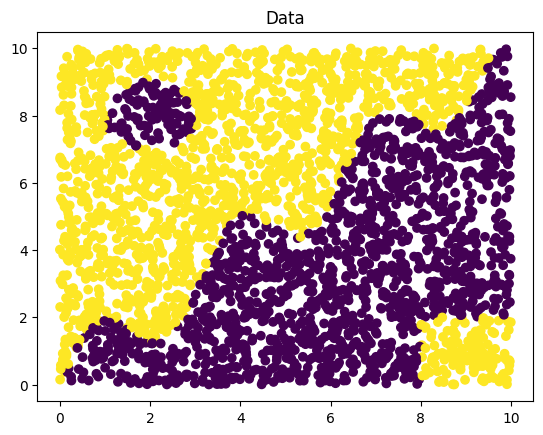

In [5]:
fig, AX = plt.subplots()

AX.scatter(X[:, 0], X[:, 1], c=y)
AX.set_title('Data')

In [5]:
permutation = np.random.permutation(X.shape[0])

train_percentage=0.8
tsize = int(train_percentage*N)

X = X[permutation]
y = y[permutation]

X_train, X_valid = X[:tsize], X[tsize:]
y_train, y_valid = y[:tsize], y[tsize:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0. 1.]
Frequencies in training dataset:  [1212 1188]


## DNN
We'll use as a starting point the model we optimnized for the first laboratory exercise

In [6]:
model = Sequential()
model.add(Dense(20,input_shape=(2,),activation='relu')) 
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(1,activation='sigmoid'))
nepoch=500

print(model.summary())

model.compile(loss='binary_crossentropy',
              #optimizer='RMSprop',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,341
Trainable params: 1,341
Non-trainabl

2023-04-05 15:20:17.409520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-05 15:20:17.409551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davide-PC): /proc/driver/nvidia/version does not exist
2023-04-05 15:20:17.409868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
fit = model.fit(X_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(X_valid,y_valid),
               verbose=1)

Epoch 1/500
48/48 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.7308 - val_loss: 0.5246 - val_accuracy: 0.8450
Epoch 2/500
48/48 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.8521 - val_loss: 0.4589 - val_accuracy: 0.8567
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.4275 - accuracy: 0.8575 - val_loss: 0.4323 - val_accuracy: 0.8567
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.4050 - accuracy: 0.8542 - val_loss: 0.4101 - val_accuracy: 0.8567
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.8558 - val_loss: 0.3781 - val_accuracy: 0.8533
Epoch 6/500
48/48 [==============================] - 0s 3ms/step - loss: 0.3621 - accuracy: 0.8587 - val_loss: 0.3558 - val_accuracy: 0.8667
Epoch 7/500
48/48 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.8675 - val_loss: 0.3416 - val_accuracy: 0.8667
Epoch 8/500
4

Epoch 59/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2075 - accuracy: 0.8988 - val_loss: 0.1902 - val_accuracy: 0.9033
Epoch 60/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2019 - accuracy: 0.9087 - val_loss: 0.1933 - val_accuracy: 0.9150
Epoch 61/500
48/48 [==============================] - 0s 3ms/step - loss: 0.2071 - accuracy: 0.9008 - val_loss: 0.1881 - val_accuracy: 0.9217
Epoch 62/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2079 - accuracy: 0.9017 - val_loss: 0.1973 - val_accuracy: 0.9033
Epoch 63/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2034 - accuracy: 0.9050 - val_loss: 0.1924 - val_accuracy: 0.8983
Epoch 64/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9054 - val_loss: 0.1996 - val_accuracy: 0.8933
Epoch 65/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2048 - accuracy: 0.9033 - val_loss: 0.1929 - val_accuracy: 0.9033
Epoch 

48/48 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9475 - val_loss: 0.1435 - val_accuracy: 0.9333
Epoch 174/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.9517 - val_loss: 0.1321 - val_accuracy: 0.9417
Epoch 175/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.9492 - val_loss: 0.1179 - val_accuracy: 0.9500
Epoch 176/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1195 - accuracy: 0.9508 - val_loss: 0.1310 - val_accuracy: 0.9400
Epoch 177/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1247 - accuracy: 0.9479 - val_loss: 0.1198 - val_accuracy: 0.9483
Epoch 178/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1245 - accuracy: 0.9529 - val_loss: 0.1394 - val_accuracy: 0.9300
Epoch 179/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.9467 - val_loss: 0.1163 - val_accuracy: 0.9500
Epoch 180/500

48/48 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.9600 - val_loss: 0.1028 - val_accuracy: 0.9450
Epoch 288/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.9558 - val_loss: 0.1182 - val_accuracy: 0.9417
Epoch 289/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1021 - accuracy: 0.9546 - val_loss: 0.1118 - val_accuracy: 0.9483
Epoch 290/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0894 - accuracy: 0.9617 - val_loss: 0.0975 - val_accuracy: 0.9550
Epoch 291/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0950 - accuracy: 0.9592 - val_loss: 0.1003 - val_accuracy: 0.9533
Epoch 292/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0943 - accuracy: 0.9558 - val_loss: 0.1472 - val_accuracy: 0.9367
Epoch 293/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1014 - accuracy: 0.9538 - val_loss: 0.1041 - val_accuracy: 0.9533
Epoch 294/500

48/48 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9683 - val_loss: 0.0812 - val_accuracy: 0.9650
Epoch 402/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9692 - val_loss: 0.0792 - val_accuracy: 0.9617
Epoch 403/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9675 - val_loss: 0.1033 - val_accuracy: 0.9517
Epoch 404/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9692 - val_loss: 0.0850 - val_accuracy: 0.9600
Epoch 405/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 0.9646 - val_loss: 0.1021 - val_accuracy: 0.9550
Epoch 406/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0738 - accuracy: 0.9654 - val_loss: 0.0825 - val_accuracy: 0.9600
Epoch 407/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9654 - val_loss: 0.1004 - val_accuracy: 0.9517
Epoch 408/500

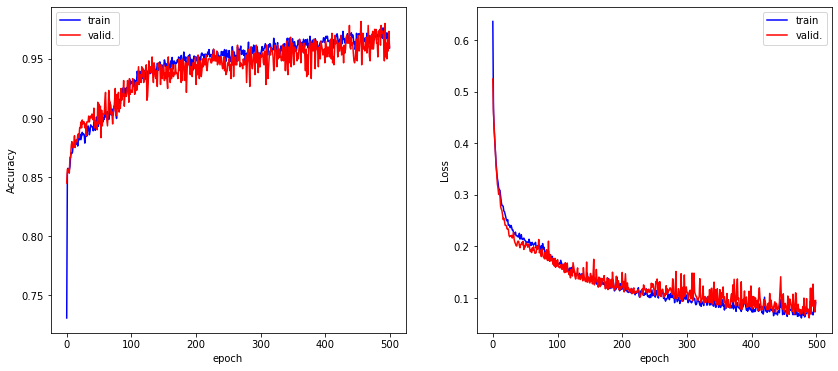

In [8]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [9]:

v=np.linspace(0,10,1000)
grid = 10*npr.rand(N,2)
#grid = np.reshape(np.meshgrid(v,v), (1000,1000,2)) 
pred = model.predict(grid)

94/94 [==============================] - 0s 760us/step


<function matplotlib.pyplot.show(close=None, block=None)>

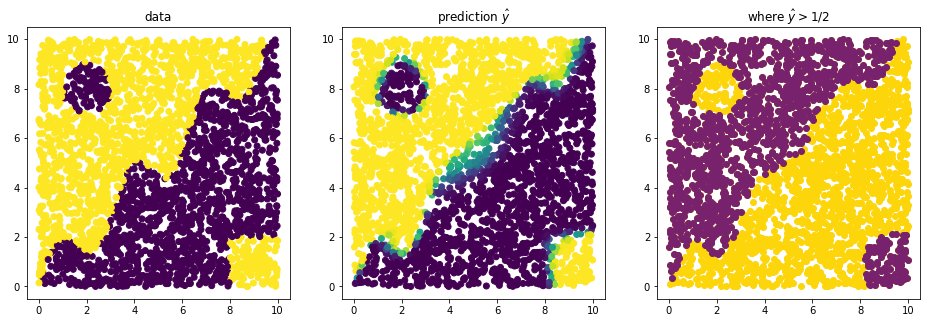

In [10]:
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(X[:,0],X[:,1],c=y)
ax.set_title("data")
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#FDD50B")
ax.scatter(grid[W1,0],grid[W1,1],c="#78226D")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

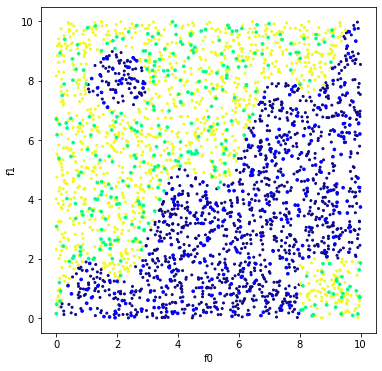

In [11]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

plt.figure(figsize=(6,6))
scat(X_train,y_train)
scat(X_valid,y_valid,cmap="winter",s=7)
plt.show()

In [12]:
def classifyx(clf=GradientBoostingClassifier(),show=False):
    clf.fit(X_train,y_train)
    y_hat = clf.predict(X_valid)
    
    print("errors: {:.2f}%".format(100*(1-clf.score(X_valid, y_valid))))

    dx = 0.02
    x_seq=np.arange(0,10+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot = clf.predict(x_plot)
    
    plt.figure(figsize=(6,6))
    plt.title(str(clf))
    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(X_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

errors: 3.00%


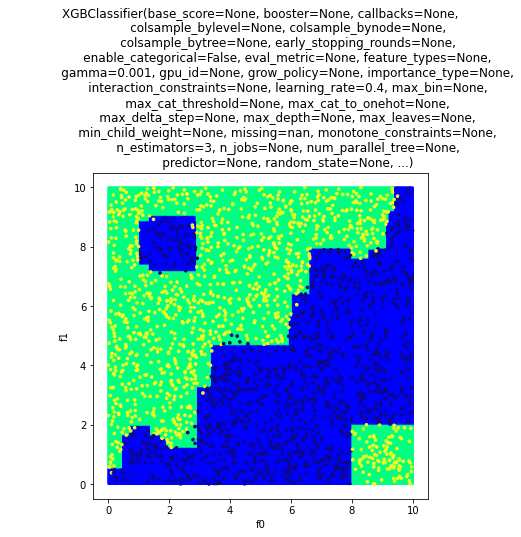

num_trees= 3


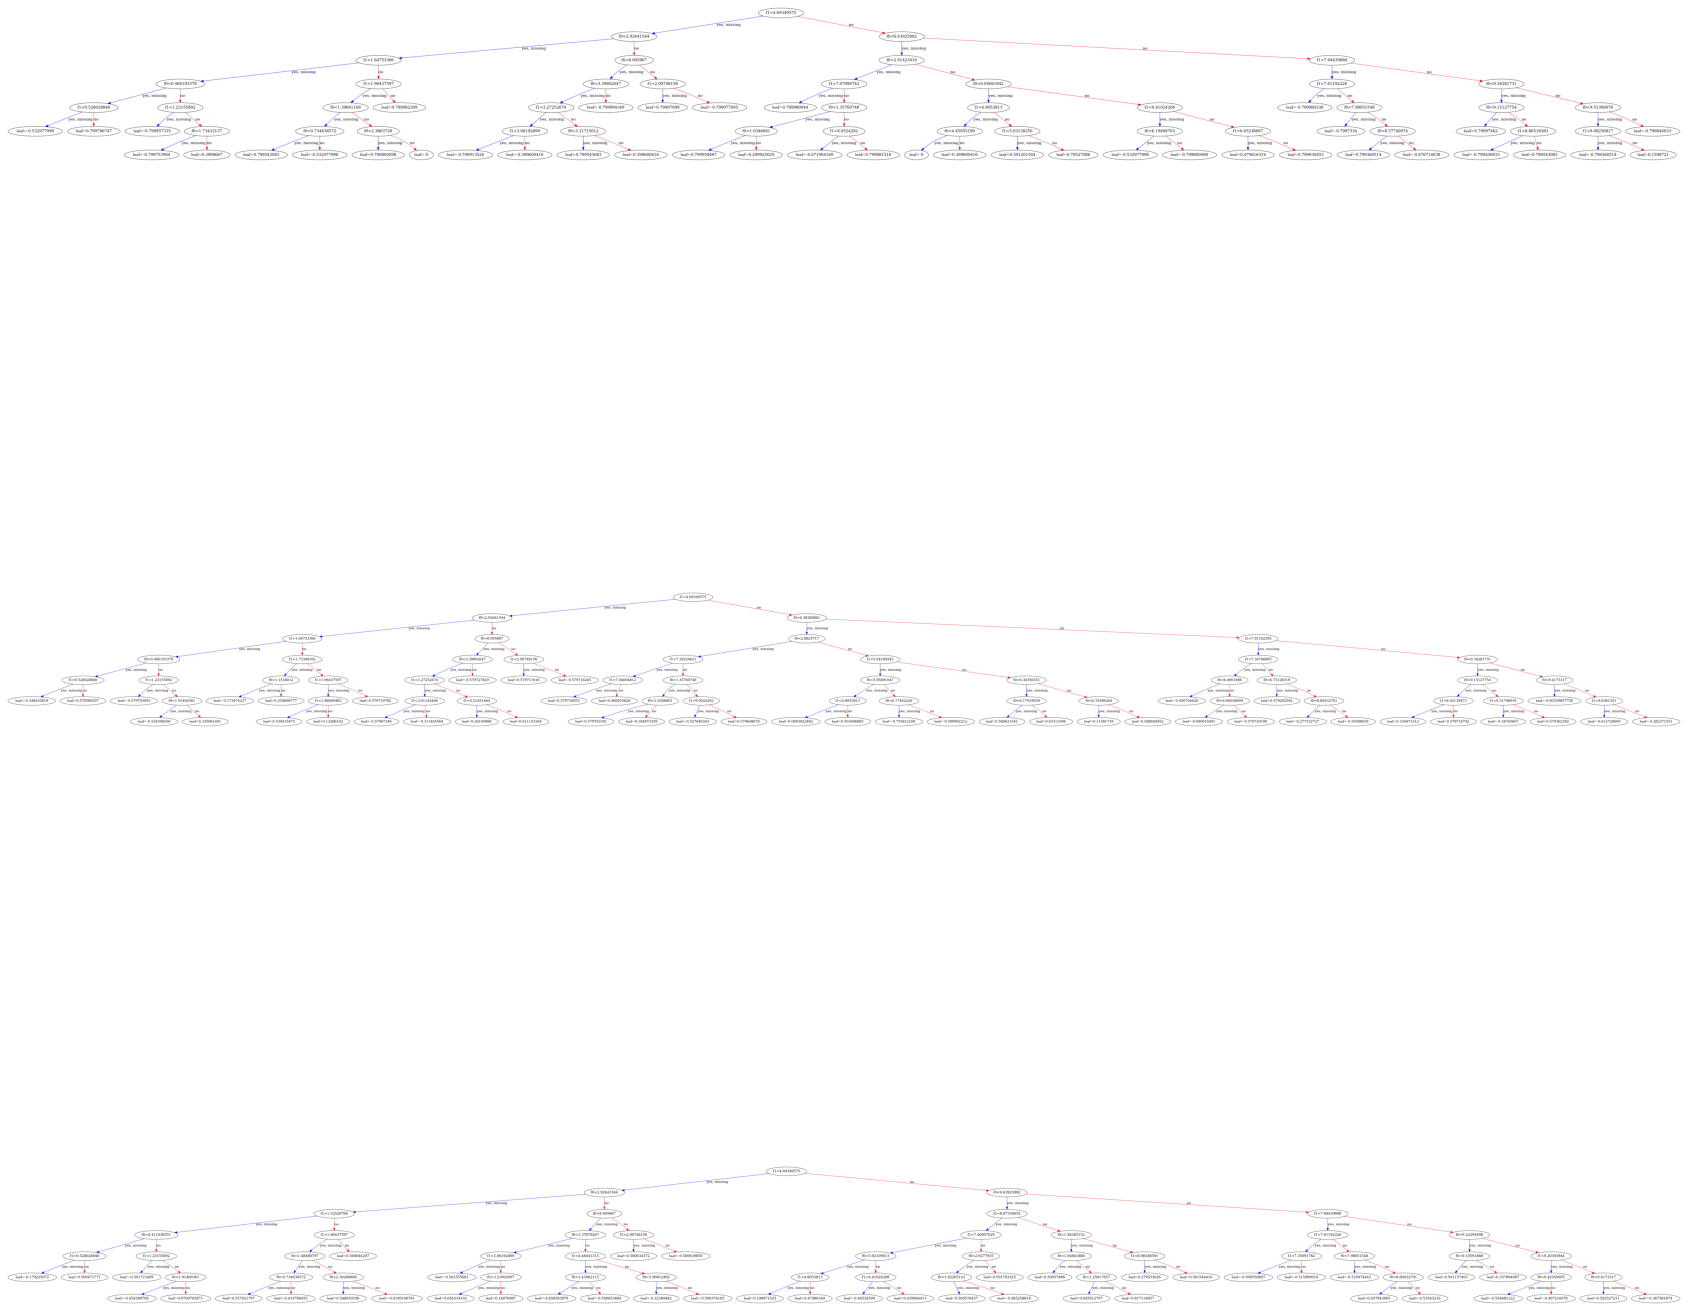

In [13]:
classifyx(XGBClassifier(seed=1,
                        objective='binary:logistic',
                        #objective="reg:squarederror",eval_metric="rmse",
                        learning_rate=0.4,
                        gamma=0.001,
                        reg_lambda=0.001, n_estimators=3),show=True)

# Varying number of samples

### Also, K-fold cross validation

In [24]:
Ns=[i for i in range(0,N+1, N//10)][1:]
nn_err=[]
xgb_err=[]
for i in Ns:
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    print(i)
    X0=X[:i]
    y0=y[:i]
    
    K=5
    vsize = int(i/K)
    nn_vals=[]
    xgb_vals=[]
    
    for k in range(K):
        try:
            X_train = np.concatenate((X0[(k+1)*vsize:], X0[:k*vsize]))
            y_train = np.concatenate((y0[(k+1)*vsize:], y0[:k*vsize]))
        except:
            if len(X0[:k*vsize])==0:
                X_train = X0[(k+1)*vsize:]
            elif len(X0[(k+1)*vsize:])==0:
                X_train = X0[:k*vsize]
            else:
                print(X0[:k*vsize], X0[(k+1)*vsize])
                raise
        X_valid = X0[k*vsize:(k+1)*vsize]
        y_valid = y0[k*vsize:(k+1)*vsize]
        #print(X_train, X_valid, y_train, y_valid)
        model = Sequential()
        model.add(Dense(20,input_shape=(2,),activation='relu')) 
        model.add(Dense(20,activation='relu'))
        model.add(Dense(20,activation='relu'))
        model.add(Dense(20,activation='relu'))
        model.add(Dropout(0.01))
        model.add(Dense(1,activation='sigmoid'))
        nepoch=500
        
        #print(model.summary())
        
        model.compile(loss='binary_crossentropy',
                      #optimizer='RMSprop',
                      optimizer='adam',
                      metrics=['accuracy'])
        fit = model.fit(X_train, y_train,
                       epochs = nepoch, batch_size = 50,
                       validation_data=(X_valid,y_valid),
                       verbose=0)
        nn_vals.append(1-fit.history["val_accuracy"][-1])
        
        clf = XGBClassifier(seed=1,
                            objective='binary:logistic',
                            #objective="reg:squarederror",eval_metric="rmse",
                            learning_rate=0.4,
                            gamma=1,
                            reg_lambda=0.001, n_estimators=3)
        clf.fit(X_train,y_train)
        
        xgb_vals.append(1-clf.score(X_valid, y_valid))
    nn_err.append((np.mean(nn_vals), np.std(nn_vals)))
    xgb_err.append((np.mean(xgb_vals), np.std(xgb_vals)))

300
600
900
1200
1500
1800
2100
2400
2700
3000


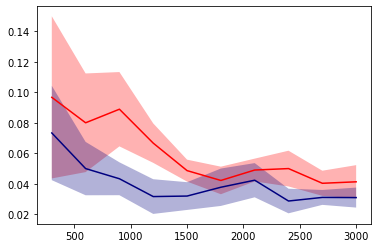

In [27]:
plt.plot(Ns, [i[0] for i in nn_err], color="red")
plt.fill_between(Ns, [i[0] for i in nn_err]+np.array([i[1] for i in nn_err]), [i[0] for i in nn_err]-np.array([i[1] for i in nn_err]), facecolor='red', alpha=0.3)
plt.plot(Ns, [i[0] for i in xgb_err], color="navy")
plt.fill_between(Ns, [i[0] for i in xgb_err]+np.array([i[1] for i in xgb_err]), [i[0] for i in xgb_err]-np.array([i[1] for i in xgb_err]), facecolor='navy', alpha=0.3)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits


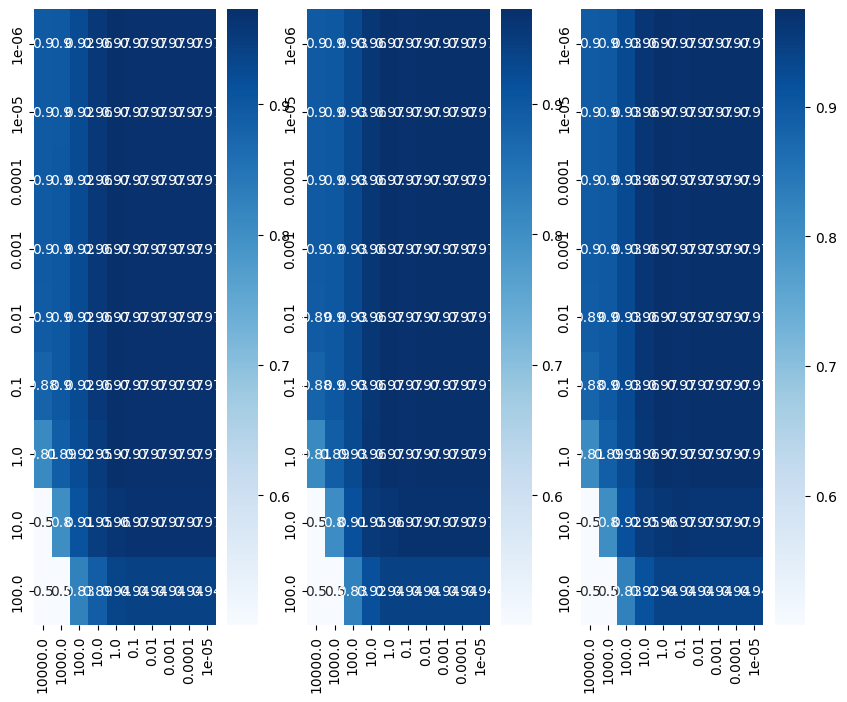

In [26]:
import seaborn as sns

fig, ax = plt.subplots(ncols = 3, figsize = (10,8))


for n_est in range(3,6):
    parameters = {'gamma': [10**i for i in range(-6,3)],
                  'reg_lambda': [10**(-i) for i in range(-4,6)] }

    clf = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        learning_rate=0.4,
                        n_estimators= n_est)

    grid_search = GridSearchCV( estimator=clf,
                                param_grid = parameters,
                                cv = 4,
                                verbose = True)
    grid_search.fit(X,y)

    df = pd.DataFrame( grid_search.cv_results_['mean_test_score'].reshape(len(parameters['gamma']),
                                                                          len(parameters['reg_lambda'])),
                      index=parameters['gamma'], columns=parameters['reg_lambda'])

    sns.heatmap(df, annot=True, cmap='Blues', ax=ax[n_est-3])